## Getting "Practical" Significance from Statistical Significance

This notebook outlines a technique to say whether two metrics are "significantly" different from each other. In other words, if you see a different performance between two groups (like male vs female) is it a "BAD" difference? Should you care?

To answer this question we bring together statistics and a risk assessment! We need to probe the owners of the AI system for their risk tolerance, and use that to contextualize any differences we see.

If you want to jump with a toy you can play with, go [to this cell](#Full-on-Toy-to-play-with)

## Setup

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import *
from scipy import stats
from time import time

In [28]:
def pooled_sd(arr1, arr2):
    n1 = len(arr1)
    n2 = len(arr2)
    sd1 = np.std(arr1)
    sd2 = np.std(arr2)
    return (((n1 - 1)*sd1**2 + (n2-1)*sd2**2) / (n1 + n2-2))**0.5

In [29]:
def get_bootstrap_indices(arr, n=1000, sample_size=None):
    if sample_size is None:
        sample_size = len(arr)
    return np.random.choice(np.arange(len(arr)), size=[sample_size,n], replace=True)

def bootstrap_samples(y_pred, y_true=None, n=1000, sample_size=None):
    indices = get_bootstrap_indices(y_pred, n=n, sample_size=sample_size)
    out = {'y_pred_bootstrap': y_pred[indices]}
    if y_true is not None:
        out['y_true_bootstrap'] = y_true[indices]
    return out

def apply_fun(bootstrap_samples, fun, requires_y_true=True):
    if requires_y_true:
        zipped = zip(bootstrap_samples['y_true_bootstrap'].T, 
                     bootstrap_samples['y_pred_bootstrap'].T)
        return np.array([fun(true, pred) for true, pred in zipped])
    else:
        return np.array([fun(s) for s in bootstrap_samples['y_pred_bootstrap'].T])

def cohens_d(arr1, arr2, verbose=False):
    if verbose:
        print(f'Mean Statistic 1: {np.mean(arr1)}', 
              f'Mean Statistic 2: {np.mean(arr2)}')
    return (np.mean(arr1)-np.mean(arr2)) / pooled_sd(arr1, arr2)

def compare(samples1, samples2, fun, requires_y_true=None, verbose=True):
    if requires_y_true is None:
        requires_y_true = False
        if 'y_true_bootstrap' in samples1:
            requires_y_true = True
    out1 = apply_fun(samples1, fun, requires_y_true)
    out2 = apply_fun(samples2, fun, requires_y_true)
    out = cohens_d(out1, out2, verbose=verbose)
    return out

## Simulation 1

Let's just get some basic bootstrapping working

In [30]:
dist1 = lambda size: np.random.normal(loc=2, 
                                      scale=1, 
                                      size=size)
dist2 = lambda size: np.random.normal(loc=0, 
                                      scale=1, 
                                      size=size)
val1 = dist1(10000)
val2 = dist2(10000)

### simple case - calculate whether distributions are different

* Sample each distribution N times
* calculate the effect size between the two distributions
* this gives you CI around the effect size

Text(0.5, 1.0, '1.9943553587751852')

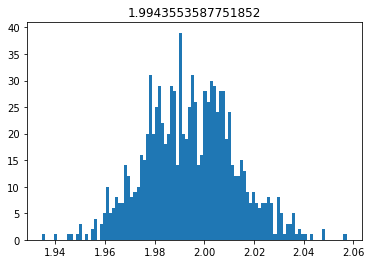

In [31]:
samples1 = bootstrap_samples(val1, sample_size=None)
samples2 = bootstrap_samples(val2, sample_size=None)

tmp1 = samples1['y_pred_bootstrap']
tmp2 = samples2['y_pred_bootstrap']

effect_sizes = [cohens_d(tmp1[:,i], tmp2[:, i]) for i in range(tmp1.shape[1])]
h=plt.hist(effect_sizes, bins=100)
plt.title(np.mean(effect_sizes))

Boom, it works. We find that the effect size is about 2, as it should be.

### What if each sample just gave one number? Like accuracy

In this case, you calculate the statistic for each sample. For instance, let's say we get correct or incorrect values for each person and want to see if the overall accuracy differs between groups. We can use the bootstrap to get a distribution of accuracies for each sample. We can compare the two distributions of accuracy, but the distributions move towards a point estimate as the sample size goes up! If we use the original sample sizes we will always get a humongous effect size! This is kind of how it should be however, because ...stats.

A proper bootstrap will use the same N as the original example. Otherwise you will underestimate the effect size. But maybe we can use that to our advantage...

First, let's go through the normal stuff.

In [32]:
# two binomial distributions (reflecting correct/incorrect for two groups)
# one distribution is 80% correct, the other is 70% correct
dist1 = lambda size: np.random.binomial(1, .8, size=size)
dist2 = lambda size: np.random.binomial(1, .7, size=size)


In [33]:
# parameteric, classic stats with a sample of 100
def to_observations(binomial_results):
    N = sum(binomial_results)
    return [N, len(binomial_results)-N]

def calc_statistic(p1, p2, n1, n2):
    p_combined = (p1*n1+p2*n2)/(n1+n2)
    z = (p1-p2)/(p_combined*(1-p_combined)*(1/n1+1/n2))**.5
    p_val = stats.norm.sf(abs(z))*2
    return z, p_val

repeats = []
for _ in range(100):
    val1 = dist1(100)
    val2 = dist2(100)
    # chisquared test
    results = {}
    out = stats.chi2_contingency([to_observations(val1), to_observations(val2)])
    results['chi_sq'] = out[1]

    # another test
    # see here https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other
    p1 = np.mean(val1)
    p2 = np.mean(val2)
    n1 = len(val1)
    n2 = len(val2)
    z, p_val = calc_statistic(p1, p2, n1, n2)
    results['z_test'] = p_val
    repeats.append(results)

Text(0.5, 0, 'pvals')

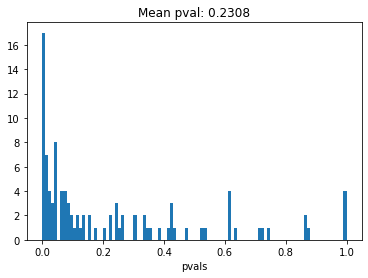

In [34]:
# we get a range of p vals for each sample
statistics = [r['z_test'] for r in repeats]
_=plt.hist(statistics, bins=100)
plt.title(f'Mean pval: {np.mean(statistics):.4f}')
plt.xlabel('pvals')

We can also estimate these p-values using the bootstrap. Or get the effect size. This is nice! We don't always have a nice closed-form solution for the difference between two statistics like we did for two binomial distributions.

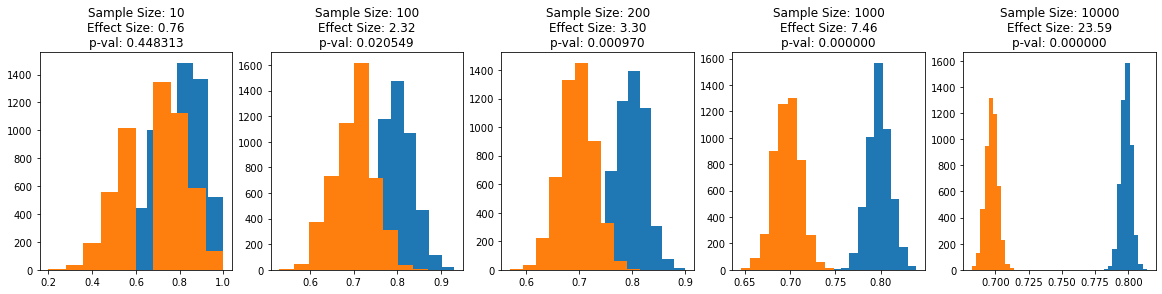

In [35]:
val1 = dist1(10000)
val2 = dist2(10000)
n=5000
sample_sizes = [10, 100, 200, 1000, None]
h= f, axes = plt.subplots(1,len(sample_sizes), figsize=(len(sample_sizes)*4,4))

for ax, sample_size in zip(axes, sample_sizes):
    sample1 = bootstrap_samples(val1, n=n, sample_size=sample_size)
    sample2 = bootstrap_samples(val2, n=n, sample_size=sample_size)
    N = len(sample1['y_pred_bootstrap']) # sample size
    statistic1 = np.mean(sample1['y_pred_bootstrap'], axis=0)
    statistic2 = np.mean(sample2['y_pred_bootstrap'], axis=0)

    effect_size = cohens_d(statistic1, statistic2)
    p_val = stats.norm.sf(abs(effect_size))*2
    ax.hist(statistic1)
    ax.hist(statistic2)
    ax.set_title(f'Sample Size: {N}\nEffect Size: {effect_size:.2f}\np-val: {p_val:f}')


### Probing your subjecive risk

Ok, so now we understand that the statistical significance of a comparison between two distributions is a function of sample size. Sample size is the important variable that makes a difference of <-----> this big and turns it into a standardized "that's pretty big" or "that's not very big". (Note - though I am talking about binaries, you can also think about this all as putting it on a standardized scale of "bigness", that is dependent on the sample size).

Said another way, once you fix the sample size, we can know whether a difference between two groups is big. Sample size essentially tells me how risky you want to be. If you would care about small differences, you need a large sample size. If you only care about big differences, you need a smaller sample size (this is the idea of [statistical power](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/))

We're gonna run with this and find a way to convert your subjective risk assessment into a sample size we can use.

-------

Let's say you want think an "accuracy difference of 10% is a big deal"... Well, actually that's not gonna be good enough as a difference in accuracy between 40% and 50% is less impressive than 85% and 95%. 

So let's be more precise with our example. You think: "if one group has an accuracy of 80%, the other group can't be more than 10% different, otherwise it's a big deal". That's a reflection of your subjective risk tolerance. And it says something about what sample size we'd need, so that we could detect the 10% difference (it's about 200 people). We can imagine probing this a number of times, in different ways. For now, let's just assume we have this one question, and from it we will get the person's risk tolerance.

What we are trying to do is make _statistical_ significance EQUAL _practical_ signifiance. We will use a "statistically significant" result to give us a YES/NO answer on whether the effect we see is a "big deal". Statistical significance is a function of **sample size**. By asking the probe above we are told what difference the person considers practically significant, we are able to determine the minimal sample size needed such that their "practically" signficant difference is also "statistically significant".

Let's turn all that into code.


In [36]:
def calc_statistic(p1, p2, n1, n2):
    p_combined = (p1*n1+p2*n2)/(n1+n2)
    z = (p1-p2)/(p_combined*(1-p_combined)*(1/n1+1/n2))**.5
    p_val = stats.norm.sf(abs(z))*2
    return z, p_val

# Let's assume both have the same sample size for our two groups for the purpose of this translation. That means we can combine n1 and n2
def calc_statistic(p1, p2, n):
    p_combined = (p1+p2)/2
    z = (p1-p2)/(p_combined*(1-p_combined)*(2/n))**.5
    p_val = stats.norm.sf(abs(z))*2
    return z, p_val

we can solve for **n**, which allows us to get out a sample size, given a z value.

In [37]:
def find_n(p1, p2, test_statistic):
    p_combined = (p1+p2)/2
    num = p_combined*(1-p_combined)*2
    denom = ((p1-p2)/test_statistic)**2
    return num/denom


We are going to define "a big deal" as a statistical significance of p<.01. Arbitrary, but makes sense. We could imagine defining a "medium deal" as p<.05 or something. Easy to change later!

In [38]:
# set up the analogy
base=.8
significant_accuracy_diff = .1

# define what "very important". Let's say "very important" means a p-val of .01
important_p_val = .01
sig_val = stats.norm.ppf(1-important_p_val/2) # zval equal to pval of .05

# it's easier to find a signfiicant effect if the deviation is AWAY from 50% than towards it
# so we will average up and down together
n_up = find_n(base+significant_accuracy_diff, base, sig_val)
n_down = find_n(base-significant_accuracy_diff, base, sig_val)
average_n = (n_up+n_down)/2
print(f'Number of people to use for this test: [{n_down}, {n_up}]\nAverage: {average_n}')

Number of people to use for this test: [248.80862253829557, 169.18986332604092]
Average: 208.99924293216824


Now we have an N. We can use this in the bootstrap for random other metrics and give "practically significant" results. "Practical significance" is defined as "statistical significance" with the number of people we found above.

We can imagine giving a short questionnaire (like a investment company does - see vanguard). The questionnaire would give a few examples like above and we would get samples of their "risk tolerance". We then apply that to any metric.

Let's make this a questionnaire

In [39]:
def run_questionnaire():
    base = .8
    important_p_val = .01
    sig_val = stats.norm.ppf(1-important_p_val/2) # zval equal to pval of .05

    print("The priveleged group has an accuracy of 80%")
    significant_accuracy_diff = float(input("How much worse would the accuracy for the unpriveleged group have to be to be a 'big deal'"))/100

    n_up = find_n(base+significant_accuracy_diff, base, sig_val)
    n_down = find_n(base-significant_accuracy_diff, base, sig_val)
    average_n = (n_up+n_down)/2
    print(f'Number of people to use for this test: [{n_down}, {n_up}]\nAverage: {average_n}')
    return int(average_n)

## Simulation - Regression

So now let's say we have a real use case. We have two distributions and our "predictive model" is worse on one than another. The way it's worse is its predictions are "noisier" (we've added a certain amount of gaussian noise). You can imagine one distribution to be the performance of the model on a priveleged group (e.g., white people) and another on an unpriveleged group (e.g. black people). Is the difference between the two models "bad"?

In [40]:
sample_size = int(average_n) # sample size we learned from our risk probe above
#config
dist1 = lambda size: np.random.exponential(size=size)
n1 = 10000
n2 = 10000
true1, true2 = dist1(n1), dist1(n2)
noise1 = .2
noise2 = .6

pred1 = true1 + np.random.normal(size=n1)*noise1
pred2 = true2 + np.random.normal(size=n2)*noise2


Here's a plot showing that difference. You can see that the cloud for the worse model is broader - it isn't doing as well!

Text(0.5, 0, 'Ground Truth')

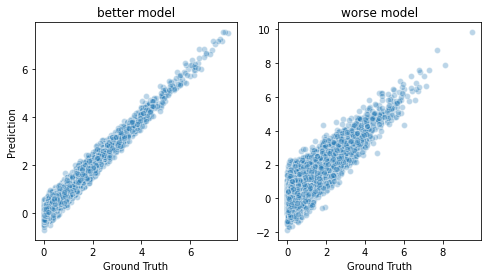

In [41]:
f, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].scatter(true1, pred1, alpha=.3, lw=1, edgecolor='w')
axes[0].set_title('better model')
axes[1].scatter(true2, pred2, alpha=.3, lw=1, edgecolor='w')
axes[1].set_title('worse model')
axes[0].set_ylabel('Prediction')
axes[0].set_xlabel('Ground Truth')
axes[1].set_xlabel('Ground Truth')

### Example

In the below example we'll run our questionnaire which will give us the critical "sample size" parameter as a function of your risk tolerance.

We'll then look at a sequence of model comparisons. The first will have a "base" level of noise, and the second will have iteratively more noise added (making it a worse model). At some point, the amount of noise will be "BAD" (too much given your risk tolerance).

In [42]:
# function to evaluate 
def evaluate(pred1, true1, pred2, true2, eval_fun, sample_size, n_boot=2000, ax=None):
    samples1 = bootstrap_samples(pred1, true1, 
                                 n_boot, sample_size=sample_size)
    samples2 = bootstrap_samples(pred2, true2, 
                                 n_boot, sample_size=sample_size)
    # on each sample compute r2_score
    requires_y_true = True
    statistic1 = apply_fun(samples1, eval_fun, requires_y_true)
    statistic2 = apply_fun(samples2, eval_fun, requires_y_true)

    # compare distributions of r2 scores
    effect_size = cohens_d(statistic1, statistic2)
    p_val = stats.norm.sf(abs(effect_size))*2
    answer = 'YES' if p_val > .01 else 'NO'
    if ax is not None:
        ax.hist(statistic1, bins=50, alpha=.5)
        ax.hist(statistic2, bins=50, alpha=.5)
        ax.set_title(f'Good?: {answer}\nSample Size: {sample_size}\nEffect Size: {effect_size:.2f}\np-val: {p_val:f}')
    return answer, p_val, effect_size

#### Full on Toy to play with

In [44]:
sample_size = run_questionnaire()

The priveleged group has an accuracy of 80%


How much worse would the accuracy for the unpriveleged group have to be to be a 'big deal' 10


Number of people to use for this test: [248.80862253829557, 169.18986332604092]
Average: 208.99924293216824


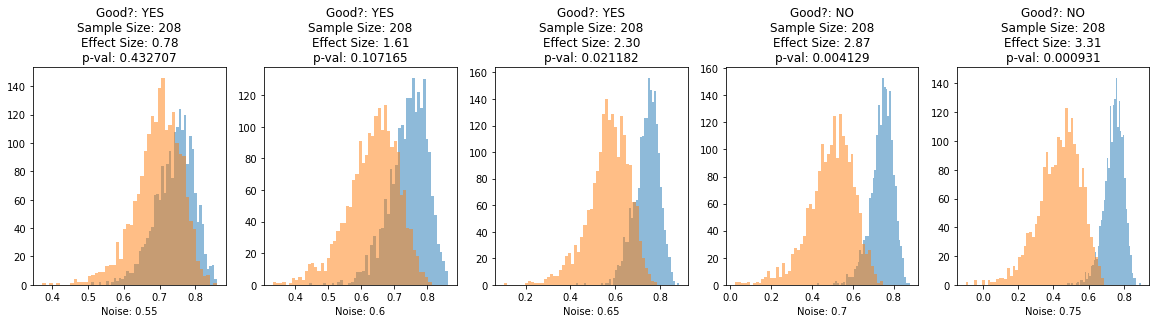

In [45]:
base_noise = .5
noises = np.array([.05, .1, .15, .2, .25])+base_noise

pred1 = true1 + np.random.normal(size=n1)*base_noise
n = len(noises)
f, axes = plt.subplots(1, n, figsize=(4*n,4))
for ax, noise in zip(axes, noises):
    pred2 = true2 + np.random.normal(size=n2)*noise
    evaluate(pred1, true1, pred2, true2, r2_score, sample_size, ax=ax)
    ax.set_xlabel(f'Noise: {noise}')

We can plot this out across noise levels. Below is a grid of "base" noises (the quality of the predictions on the priveleged group) vs the comparison noise (the quality of predictions for the unpriveleged group).

The green boxes are "GOOD", the blue ones are "BAD". You can see that as the noise of the comparison predictions gets worse the predictions becomes labeled "BAD". How much noise is necessary to get a "BAD" rating is dependent on how much noise is in the base performance.

Intuitively, this makes sense. If the model is GREAT at prediction one group of people (the priveleged group), then a smaller performance decrement is a large _relative_ change. If the model is just ok at prediction with the priveleged group then a larger amount of noise would need to be added to have the same kind of relative change.

In [54]:
base_list = np.arange(.05,.8, .025)
comparison_list = np.arange(.05,.8, .025)
sample_size = run_questionnaire()

The priveleged group has an accuracy of 80%


How much worse would the accuracy for the unpriveleged group have to be to be a 'big deal' 10


Number of people to use for this test: [248.80862253829557, 169.18986332604092]
Average: 208.99924293216824


In [55]:
n=10000
true1, true2 = dist1(n), dist1(n)

results = []
for base in base_list:    
    pred1 = true1 + np.random.normal(size=n)*base
    base_results = [.5]*len(comparison_list)
    for i, comparison in enumerate(comparison_list):
        if comparison == base:
            base_results[i] = 1
        if comparison > base:
            pred2 = true2 + np.random.normal(size=n)*comparison
            a, p, e= evaluate(pred1, true1, pred2, true2, r2_score, sample_size, n_boot=500)
            base_results[i] = 1 if a == "YES" else 0
    results.append(base_results)

Text(0.5, 1.0, 'Is the performance difference Good (green)?')

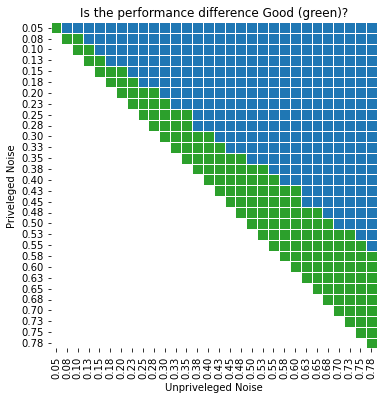

In [56]:
import seaborn as sns
df = pd.DataFrame(results, 
                  index=[f'{i:.2f}' for i in base_list], 
                  columns=[f'{i:.2f}' for i in comparison_list])
palette = list(sns.color_palette(n_colors=3))
plt.figure(figsize=(6,6))
sns.heatmap(df, 
            cmap=palette, 
            cbar=False, 
            mask = df==.5,
            square=True, linewidth=1)
plt.ylabel('Priveleged Noise')
plt.xlabel('Unpriveleged Noise')
plt.title('Is the performance difference Good (green)?')

# Test out script version

In [57]:
from bootstrap import Sampler
from fairlearn.metrics import MetricFrame
from credoai.modules import FairnessModule, FairnessFunction
from bootstrap import *
from sklearn.metrics import *
import pandas as pd
import numpy as np

In [92]:
questionnaire = RiskQuestionnare()
q_output = questionnaire.run()

The priveleged group has an accuracy of 80%...



How much worse would the accuracy for the
unpriveleged group have to be to be a 'BIG deal' 15


Number of people to use for this test: [117.58511198476478, 64.5059391765951]
Average: 91.04552558067994
The priveleged group has an accuracy of 80%...



How much worse would the accuracy for the
unpriveleged group have to be to be a 'MEDIUM
deal' 10


Number of people to use for this test: [248.80862253829557, 169.18986332604092]
Average: 208.99924293216824
The priveleged group has an accuracy of 80%...



How much worse would the accuracy for the
unpriveleged group have to be to be a 'SMALL deal' 5


Number of people to use for this test: [925.5680758424575, 766.3305574179484]
Average: 845.9493166302029


In [93]:
#config
dist1 = lambda size: np.random.exponential(size=size)
n1 = 10000
n2 = 10000
true1, true2 = dist1(n1), dist1(n2)

# pred setup
pred1 = true1 + np.random.normal(size=n1)*.2
pred2 = true2 + np.random.normal(size=n2)*.25

#metric setup
from functools import partial
rmse = partial(mean_squared_error, squared=False)
metrics = {'r2_score': r2_score, 
           'mse': mean_squared_error, 
           'rmse': rmse,
           'mae': mean_absolute_error}
wrapped_metrics = {FairnessFunction(k, v) for k, v in metrics.items()}

cat_y_true = np.hstack([true1, true2])
cat_y_pred = np.hstack([pred1, pred2])
sensitive_feature = np.array(['male']*len(true1)+['female']*len(true2))

## With function associated with module

In [94]:
self = lambda _: 3
self.module = FairnessModule

def run_bootstrapped(y_true, y_pred, sensitive_features,
                     method='between_groups',
                     n_rep=1000, sample_size=500, thresh=.01):
    arrays = {'y_true': y_true,
              'y_pred': y_pred,
              'sensitive_feature': sensitive_features}
    sampler = Sampler(verbose=False)
    samples = sampler.create_samples(arrays, n_rep=n_rep, sample_size=sample_size)
    
    results = []
    for rep in range(n_rep):
        y_true, y_pred, sensitive = [samples[key][:, rep] 
                                     for key in ['y_true', 'y_pred', 'sensitive_feature']]
        mod=self.module(wrapped_metrics, sensitive, y_true, y_pred)
        results.append(mod.run().get_results())
        
    # concat results
    all_results = {}
    for key in results[0].keys():
        all_results[key] = pd.concat([r[key] for i, r in enumerate(results)])
        
    # eval
    out = {}
    df = all_results['disaggregated_results']
    avg_results = df.groupby(df.index).mean()

    method = 'between_groups'
    for metric in metrics.keys():
        if method == 'to_overall':
            group1 = 'overall'
            group2 = abs(avg_results[metric] - avg_results.loc['overall', metric]).idxmax()
        elif method == 'between_groups':
            group1 = avg_results[metric].idxmin()
            group2 = avg_results[metric].idxmax()
        out[metric] = sampler.evaluate(df.loc[group1, metric], 
                                       df.loc[group2, metric], 
                                       thresh=thresh)
    return pd.DataFrame(out)

In [100]:
%%time
out=run_bootstrapped(cat_y_true, cat_y_pred, sensitive_feature,
                    **q_output['small'])

CPU times: user 10.9 s, sys: 30.6 ms, total: 10.9 s
Wall time: 10.9 s


In [101]:
out

,r2_score,mse,rmse,mae
effect_size,-2.451608,-6.122771,-6.30474,-5.746909
p_val,0.014222,0.0,0.0,0.0
rejected,False,True,True,True


#### Sampling on metric frames

In [97]:
%%time
total_out = {}
reps = 1000
sampler = Sampler(verbose=False)
for deal, params in q_output.items():
    sample_size = params['sample_size']
    thresh = params['thresh']

    # create samples
    n_rep = reps
    samples = sampler.create_samples({'y_true': cat_y_true,
                                      'y_pred': cat_y_pred,
                                      'sensitive_feature': sensitive_feature},
                                     n_rep=n_rep,
                                     sample_size=sample_size)
    # run fairness
    results = []
    for rep in range(n_rep):
        y_true, y_pred, sensitive = [samples[key][:, rep] 
                                     for key in ['y_true', 'y_pred', 'sensitive_feature']]
        frame = MetricFrame(
            metrics = metrics,
            y_true = y_true,
            y_pred = y_pred,
            sensitive_features = sensitive
        )
        results.append(frame.by_group)
    results = pd.concat(results, axis=1)

    # eval
    out = {}
    for metric in metrics.keys():
        out[metric] = sampler.evaluate(results.loc['female', metric], 
                                       results.loc['male', metric], 
                                       thresh=thresh)
    total_out[deal] = out

# convert to df
all_df = []
for deal in total_out.keys():
    df = pd.DataFrame(total_out[deal])
    all_df.append(pd.concat({deal: df}, names=['Deal']))
df = pd.concat(all_df)
df

CPU times: user 15.1 s, sys: 63.2 ms, total: 15.2 s
Wall time: 15.1 s


r2_score       mse      rmse       mae
Deal                                                      
big    effect_size -0.714339  1.942936  1.997358  1.879743
       p_val        0.475017  0.052024  0.045786  0.060143
       rejected        False     False     False     False
medium effect_size -1.204535  3.100577  3.182092  2.939004
       p_val        0.228383  0.001931  0.001462  0.003293
       rejected        False      True      True      True
small  effect_size -2.434558  6.064324  6.203221  5.761114
       p_val         0.01491       0.0       0.0       0.0
       rejected        False      True      True      True

### working without fairlearn is much faster

In [66]:
%%time
for _ in range(reps):
    a=r2_score(y_true[sensitive=='female'], y_pred[sensitive=='female'])
    b=r2_score(y_true[sensitive=='male'], y_pred[sensitive=='male'])
    a-b

NameError: name 'y_true' is not defined